In [1]:
!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

In [2]:
pip install fastai==2.7.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 928.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.5.27
    Uninstalling fastcore-1.5.27:
      Successfully uninstalled fastcore-1.5.27
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.9
    Uninstalling fastai-2.7.9:
      Successfully uninstalled fastai-2.7.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have 

In [3]:
#Other installs can go here: (e.g. base_rbt etc)

In [ ]:
#Other imports (add to this list)
import fastai
from fastai.vision.all import *
fastai.__version__

In [5]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
from sklearn.metrics import classification_report
import torch
from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import *
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

## Read image filenames from the dataset folders

In [6]:
train_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Train'
test_dir='../input/skin-cancer-isic/skin_cancer_ISIC/Test'

In [7]:
class_names0 = os.listdir(train_dir)
class_names = sorted(class_names0)
num_class = len(class_names)
image_files = [[os.path.join(train_dir, class_name, x) 
               for x in os.listdir(os.path.join(train_dir, class_name))] 
               for class_name in class_names]

image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
num_total = len(image_label_list)

## Now we can get the (unlabelled) training set:

In [17]:
#Helper functions to get the training set
import re
def extract_text(string):
    # Use the compile method to create a RegexObject
    pattern = re.compile(r'/Train/(.*?)/ISIC')

    # Use the search method of the RegexObject to find the pattern in the string
    match = pattern.search(string)

    # If a match is found, return the matched text
    if match:
        return match.group(1)
    # If no match is found, return None
    else:
        
        return None
    
    
def label_func(x): return extract_text(x.as_posix())

#file names
fnames = get_image_files(train_dir)

#Extract training set (fnames_train)
max_cat=100 #maximum number of samples per category. 
count_dict = {i:0 for i in class_names}
fnames_train = []
for i in fnames:
    st=extract_text(i.as_posix())
    
    if count_dict[st]<max_cat: #no more than 100 samples per category
        fnames_train.append(i)
        count_dict[st]+=1
        
#sanity check
labels_train = [extract_text(i.as_posix()) for i in fnames_train]
tem_dict = {i:labels_train.count(i) for i in labels_train}
tem_dict

{'pigmented benign keratosis': 100,
 'melanoma': 100,
 'vascular lesion': 100,
 'actinic keratosis': 100,
 'squamous cell carcinoma': 100,
 'basal cell carcinoma': 100,
 'seborrheic keratosis': 77,
 'dermatofibroma': 95,
 'nevus': 100}

## Build the dataloader

In [18]:
bs=64 
size=128
item_tfms = [Resize(size)]
dls_train = ImageDataLoaders.from_path_func(train_dir, fnames_train, label_func,
                                      bs=bs,
                                      item_tfms=Resize(size),
                                      valid_pct=0,
                                    )


## View the images

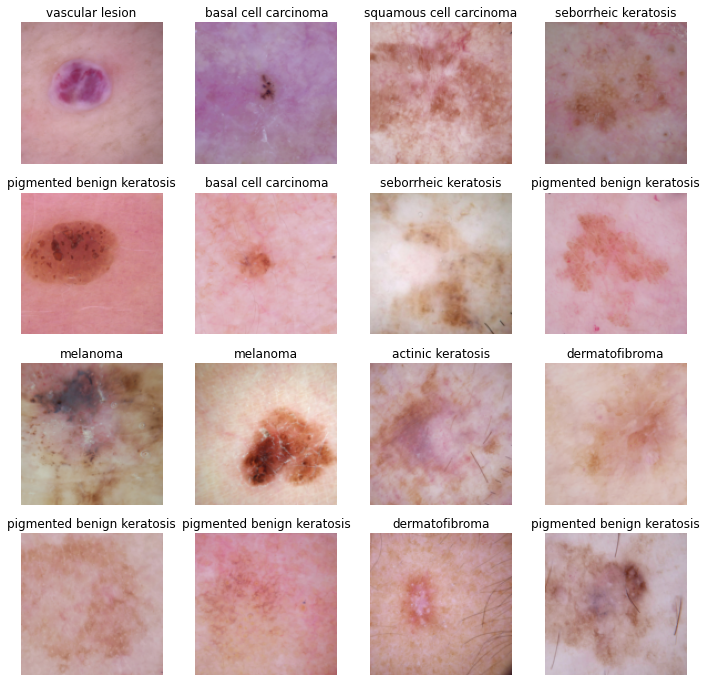

In [20]:
dls_train.show_batch(max_n=16)